# Distinguishing dataset



**Dataset:** [EEG data for Mental Attention State Detection](
https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/data)

**Article:** [Distinguishing mental attention states of humans via an EEG-based passive BCI using machine learning methods](https://sci-hub.ru/10.1016/j.eswa.2019.05.057)


Маркировка засчет того что известна сложность маршрута между: focused, unfocused,drowsy



1. могу ли я сделать видео визуализацию по картинкой головы. То есть чтобы было видео как сигнал меняется со временем по голове.
2. Есть ли какая-то проверка на линейнную зависимость каналов


MNE continuous data working


# Import libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
plt.ion()


import mne
mne.set_log_level('error')


import os
import random
import shutil

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.options.display.max_columns = None # показываем все колонки

# Reading files

In [2]:
def load_distinguishing_file(file_path):

    eeg_channels = [
        'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7',
        'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'
    ]

    sfreq = 128
    voltage_resolution = 0.51e-6

    
    mat_data = scipy.io.loadmat(file_path)
    data = mat_data['o'][0][0]['data']
    eeg_data = pd.DataFrame(data).iloc[:, 4:18].to_numpy().T


    scaled_data = eeg_data * voltage_resolution

    info = mne.create_info(
        ch_names=eeg_channels, 
        sfreq=sfreq, 
        ch_types=['eeg'] * len(eeg_channels)
    )
    raw = mne.io.RawArray(scaled_data, info)
    raw.set_montage('standard_1020')


    return raw

In [3]:
data_path = 'datasets\\Distinguishing\\'

raw_objects = []
events = []
metadata = []



for file_index in range(1, 35):  # от 1 до 34 включительно
    file_name = f'eeg_record{file_index}.mat'
    file_path = os.path.join(data_path, file_name)



    if not os.path.exists(file_path):
        print(f"Файл не найден, пропускаю: {file_name}")
        continue


    # Raw
    raw = load_distinguishing_file(file_path)
    raw.crop(tmax=20 * 60)
    raw = raw.pick_channels(['F3', 'F4', 'F7', 'F8', 
                                'FC5', 'FC6', 'O1', 'O2', 
                                'P7', 'P8', 'T7', 'T8'])
    raw_objects.append(raw)



    # Events
    focused_events = mne.make_fixed_length_events(
        raw,
        id=1,
        start=0,
        stop=600,
        duration=0.25,
        overlap=0.0
    )

   
    unfocused_events = mne.make_fixed_length_events(
        raw,
        id=0,
        start=600,
        stop=1200,
        duration=0.25,
        overlap=0.0
    )

    
    events_one = np.vstack([focused_events, unfocused_events])
    events.append(events_one)

    # Metadata
    participant_id = min((file_index - 1) // 7 + 1, 5)
    day_id = (file_index - 1) % 7 + 1

    meta_one = pd.DataFrame({
        "subject": [f'participant_{participant_id}'] * len(events_one),
        "session": [f'day_{day_id}'] * len(events_one)
    })

    metadata.append(meta_one)



# Raw
raw_objects = [raw_objects[0].copy()] + raw_objects[1:]
first_samps = [r.first_samp for r in raw_objects]
last_samps  = [r.last_samp for r in raw_objects]

distinguishing_full = mne.concatenate_raws(raw_objects)
del raw_objects

# Events
event_dict = {
    'focused': 1,
    'unfocused': 0
}
events = mne.concatenate_events(events, first_samps, last_samps)

# Metadata
metadata = pd.concat(metadata, ignore_index=True)

# Events plot

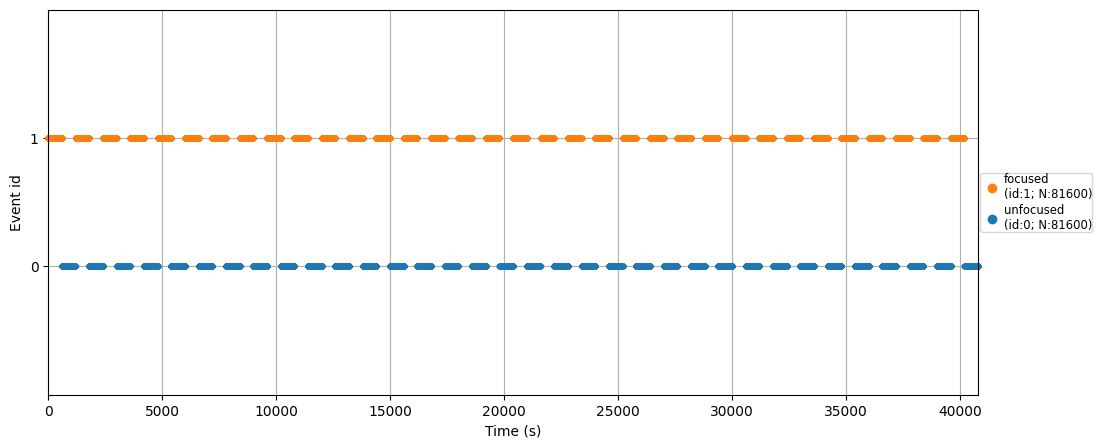

In [4]:

fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    events,
    distinguishing_full.info["sfreq"],
    event_id=event_dict,
    axes=ax
)
plt.show()

# Preprocessing

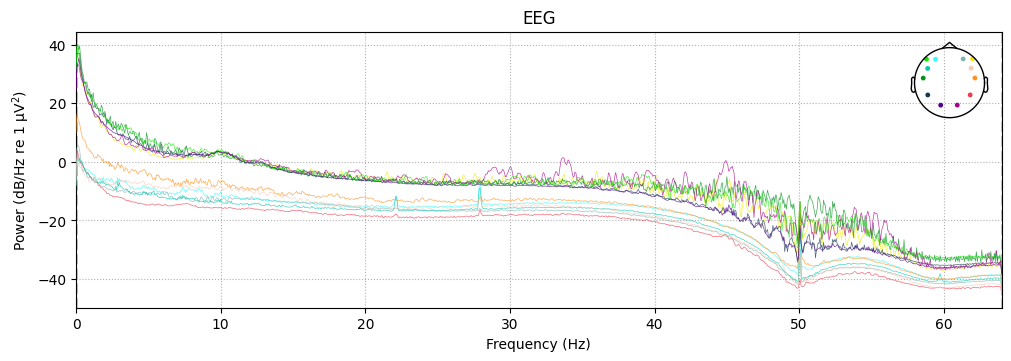

In [5]:
distinguishing_full.compute_psd().plot(show=False);

In [6]:
# Artifact removal with ICA

notch_freqs = [50]
ica_l = 1.0
ica_h = 45.0

raw_for_ica = distinguishing_full.copy()
raw_for_ica.notch_filter(freqs=notch_freqs) # Notch filter
raw_for_ica.filter(l_freq=ica_l, h_freq=ica_h) # Bandpass filter specially for ICA

ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)
ica.fit(raw_for_ica)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,51 iterations on raw data (5222434 samples)
ICA components,7
Available PCA components,12
Channel types,eeg
ICA components marked for exclusion,—


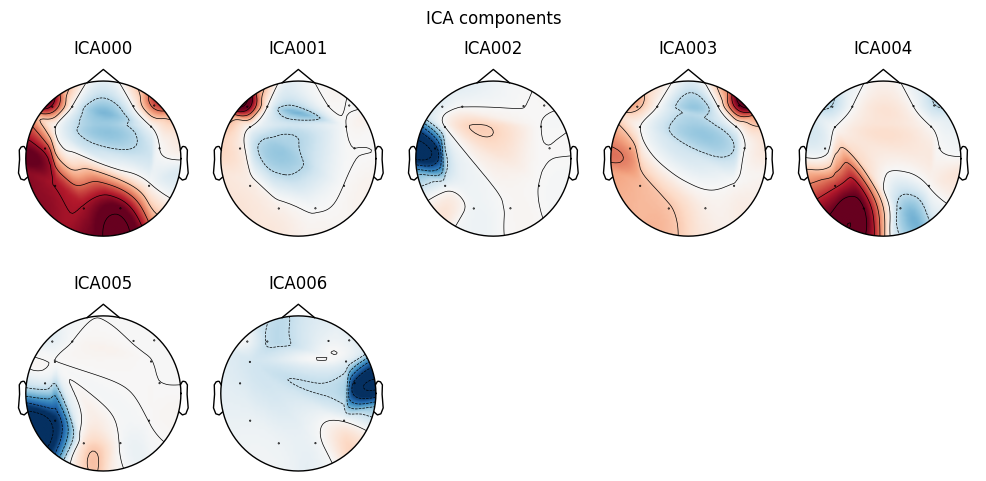

In [7]:
ica.plot_components();

In [8]:
max_ic = 2       # Максимальное число EOG-компонент, которые можно исключить
z_thresh = 2.4   # Начальный Z-порог
z_step = 0.05    # Шаг уменьшения порога

num_excl = 0
final_indices = []

while num_excl < max_ic and z_thresh > 0:
    eog_indices, eog_scores = ica.find_bads_eog(
        raw_for_ica,  # или epochs
        ch_name=['F3', 'F4', 'F7', 'F8'],
        threshold=z_thresh
    )
    num_excl = len(eog_indices)
    final_indices = eog_indices

    if num_excl < max_ic:
        z_thresh -= z_step
    else:
        break

# Назначаем найденные индексы для удаления
ica.exclude = final_indices


# Применяем
ica.apply(distinguishing_full)

print(f"Final Z-threshold = {z_thresh:.2f}")
print(f"Components to exclude: {ica.exclude}")


Final Z-threshold = 2.05
Components to exclude: [np.int64(1), np.int64(0), np.int64(6)]


In [9]:
# Filtering
final_l = 0.01
final_h  = 43

distinguishing_full.filter(final_l, final_h)

<RawArray | 12 x 5222434 (40800.3 s), ~478.1 MiB, data loaded>

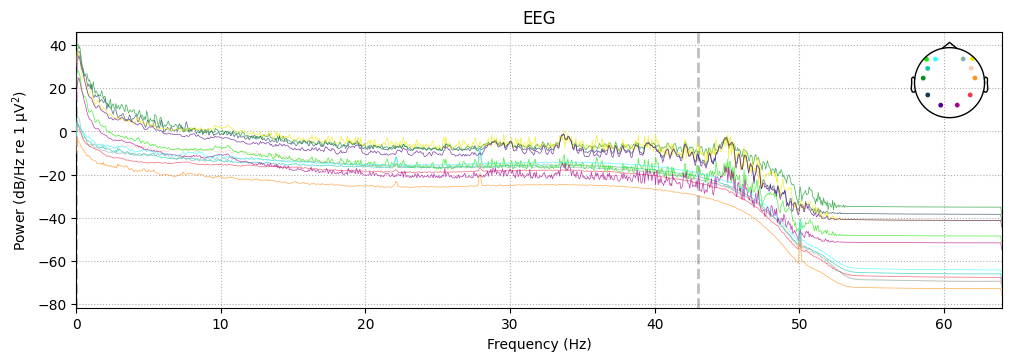

In [10]:
distinguishing_full.compute_psd().plot(show=False);

# New events plot

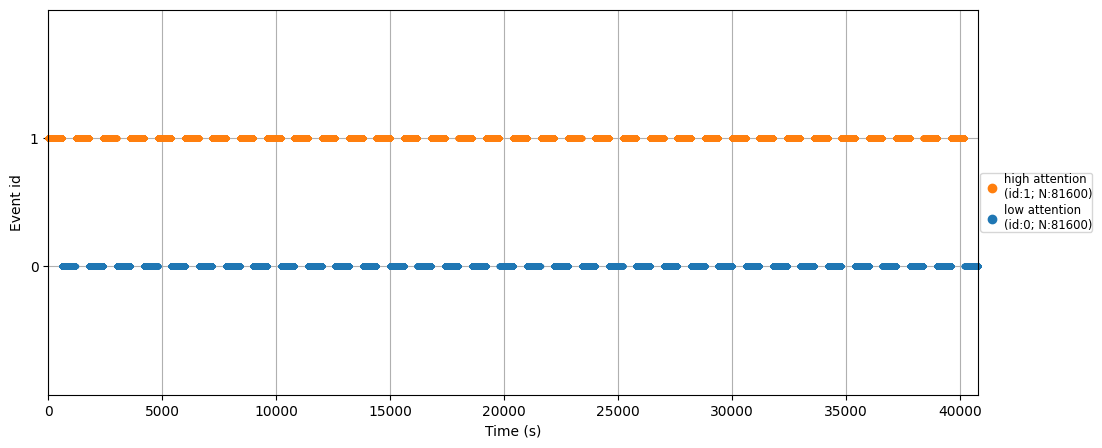

In [11]:
merge_dict = {
    'low attention': 0,   # unfocused
    'high attention': 1      # focused
}


fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    events,
    distinguishing_full.info["sfreq"],
    event_id=merge_dict,
    axes=ax
)
plt.show()

# Segmentation

In [ ]:
tmin = 0.0
tmax = 1.0

file_path = r'epochs\sam40_full_epochs.fif'

distinguishing_epochs = mne.Epochs(
    distinguishing_full,
    events=events,
    event_id=merge_dict,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    preload=True,
    reject_by_annotation=True,
    metadata=metadata
)

distinguishing_epochs.save(file_path, overwrite=True)

shutil.make_archive(
    base_name=os.path.splitext(file_path)[0] ,
    format="zip",
    root_dir=os.path.dirname(file_path),
    base_dir=os.path.basename(file_path)
)

os.remove(file_path)

distinguishing_epochs